<div align="center">

#Attention Is All You Need


---


</div>
Paper [Link](https://arxiv.org/pdf/1706.03762.pdf)


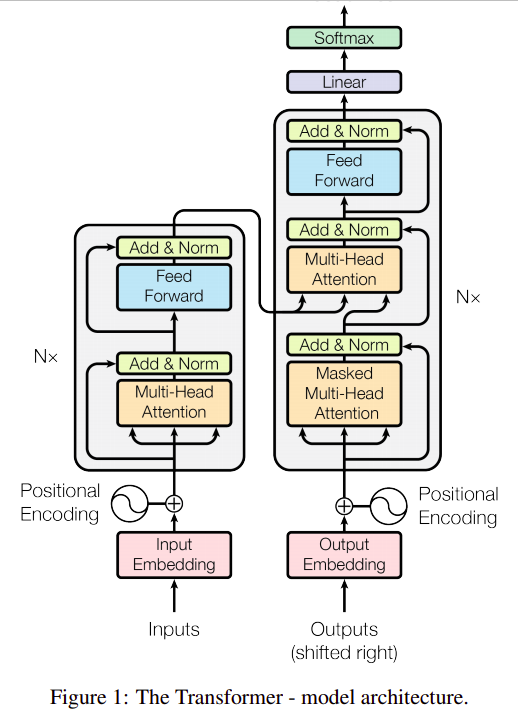


In [1]:
import torch
from torch import nn
import math

'''Embedder class handle the word embedding followed by the positional encoding'''
class Embedder(nn.Module):
  def __init__(self, vocab_size, embedding_size, max_seq_len):
    super().__init__()
    self.embedding_layer  = nn.Embedding(vocab_size, embedding_size) 
    PE                    = torch.zeros(max_seq_len, embedding_size) 

    for pos in range(max_seq_len):
      for i in range(0, embedding_size, 2):
        PE[pos, i]     = math.sin(pos/10000**((2 * i)/embedding_size))       #if i even
        PE[pos, i + 1] = math.cos(pos/10000**((2 * (i + 1))/embedding_size)) #if i odd

    #PE.shape = (1, max_seq_len, embedding_size)
    PE = PE.unsqueeze(0)
    self.register_buffer('PE', PE) #save PE in 'state_dict', but not trained by optimizer
  
  def forward(self, inp):
    #inp.shape = (batch_size, seq_len)
    seq_len  = inp.shape[1]

    #embedded.shape = (batch_size, seq_len, embedding_size)
    embedded            = self.embedding_layer(inp)
    positional_embedded = self.PE[:, :seq_len] + embedded #Positional Encoding

    return positional_embedded

class Self_Attention(nn.Module):
  def __init__(self, embedding_size = 256, max_seq_len = 100):
    super().__init__()
    self.embedding_size = embedding_size

    self.mask_matrix = torch.full((max_seq_len, max_seq_len), float("-1e20"))
    self.mask_matrix = torch.triu(self.mask_matrix, diagonal = 1)
    
    self.Linear      = nn.Linear(embedding_size, embedding_size)
    self.Softmax     = nn.Softmax(dim = 2) #dim 2 refer to embedding_size -> (batch_size, seq_len, embedding_size)
      
  def forward(self, query, key, value, masked = False):
    #query, key, value shape = (batch_size, seq_len, embedding_size)
    query = self.Linear(query)
    key   = self.Linear(key)
    value = self.Linear(value)

    #key_Transpose = (batch_size, embedding_size, seq_len)

    key_Transpose = torch.transpose(key, 1, 2)
    score         = torch.bmm(query, key_Transpose)
    #scaled_score = (batch_size, seq_len, seq_len)
    scaled_score  = score / math.sqrt(self.embedding_size)

    if masked:
      scaled_score = scaled_score + self.mask_matrix #this is the only difference, ho yea
      attn_weight  = self.Softmax(scaled_score)
    else:
      attn_weight   = self.Softmax(scaled_score) 
    
    output        = torch.bmm(attn_weight, value)

    return output

''''''
class MultiHeaded_Attention(nn.Module):
  def __init__(self, embedding_size, max_seq_len, num_heads = 8):
    super().__init__()
    self.num_heads = num_heads
    self.head_dim  = embedding_size // self.num_heads

    assert (self.num_heads * self.head_dim == embedding_size), "the division between 'embedding_size' with 'num_heads' must be integer"

    self.self_attn        = Self_Attention(embedding_size = self.head_dim, max_seq_len = max_seq_len)
    self.Linear           = nn.Linear(embedding_size, embedding_size)
  
  def forward(self, query = None, key = None, value = None, masked = False):
    #embedded.shape = (batch_size, seq_len, embedding_dim) 
    batch_size      = query.shape[0]
    seq_len         = query.shape[1]
    
    #Split Query, Key, and Value into N number of head.
    splited_query = query.reshape(self.num_heads, batch_size, seq_len, self.head_dim)
    splited_key   = key.reshape(self.num_heads, batch_size, seq_len, self.head_dim)
    splited_value = value.reshape(self.num_heads, batch_size, seq_len, self.head_dim)

    #initialize empty tensor to store final concatentation
    joined_heads = torch.Tensor

    #After get splited, feed each head into self_attn layer and concatenate the output.
    for h in range(self.num_heads):
      query = splited_query[h]
      key   = splited_key[h]
      value = splited_value[h]

      #head_out.shape = (batch_size, seq_len, head_dim)
      if masked:
        head_out        = self.self_attn(query, key, value, masked = True)
      else:
        head_out        = self.self_attn(query, key, value)

      if h == 0:
        joined_heads = head_out
      else:
        #Concatenate the current head_out with previous joined_heads
        joined_heads = torch.cat((head_out, joined_heads),  dim = 2)    
    
    joined_heads = self.Linear(joined_heads)

    return joined_heads


''''''
class Encoder_Block(nn.Module):
  def __init__(self, embedding_size, max_seq_len):
    super().__init__()
    self.MultiHeaded_Attention = MultiHeaded_Attention(embedding_size, 
                                                       max_seq_len)
    
    self.norm                  = nn.LayerNorm(embedding_size)
    
    self.feed_forward          = nn.Sequential(
                                 nn.Linear(embedding_size, embedding_size),
                                 nn.ReLU(),
                                 nn.Linear(embedding_size, embedding_size)
    )

  def forward(self, encoder_in):
    out = self.MultiHeaded_Attention(query = encoder_in,
                                     key   = encoder_in,
                                     value = encoder_in
                                     )
    
    norm_out1 = self.norm(out + encoder_in)
    FF_out    = self.feed_forward(norm_out1)
    norm_out2 = self.norm(FF_out + norm_out1)

    return norm_out2                               

''''''
class Decoder_Block(nn.Module):
  def __init__(self, embedding_size, max_seq_len):
    super().__init__()
    self.MultiHeaded_Attention = MultiHeaded_Attention(embedding_size,
                                                       max_seq_len)
    
    self.norm                  = nn.LayerNorm(embedding_size)
    
    self.feed_forward          = nn.Sequential(
                                 nn.Linear(embedding_size, embedding_size),
                                 nn.ReLU(),
                                 nn.Linear(embedding_size, embedding_size)
    )

  def forward(self, encoder_out, decoder_in):
    out = self.MultiHeaded_Attention(query  = decoder_in,
                                     key    = decoder_in,
                                     value  = decoder_in,
                                     masked = True)
    
    norm_out1 = self.norm(out + decoder_in)

    out = self.MultiHeaded_Attention(query = encoder_out,
                                     key   = encoder_out,
                                     value = norm_out1)
    
    
    norm_out2 = self.norm(out + norm_out1)

    FF_out     = self.feed_forward(norm_out2)
    norm_out3  = self.norm(FF_out + norm_out2)

    return norm_out3


''''''
class Transformer(nn.Module):
  def __init__(self, SRCvocab_size, TRGvocab_size, embedding_size, max_seq_len, num_layers = 6):
    super().__init__()
    self.num_layers    = num_layers
    self.max_seq_len   = max_seq_len

    self.SRC_embedder  = Embedder(SRCvocab_size, embedding_size, max_seq_len)
    self.TRG_embedder  = Embedder(TRGvocab_size, embedding_size, max_seq_len)
    
    self.encoder       = Encoder_Block(embedding_size, max_seq_len)
    self.decoder       = Decoder_Block(embedding_size, max_seq_len)

    self.linear        = nn.Linear(embedding_size, TRGvocab_size)
    self.softmax       = nn.Softmax(dim = 2)

  def forward(self, src, trg):  
    batch_size = src.shape[0]

    Fixed_src  = torch.ones((batch_size, self.max_seq_len), dtype = torch.long)
    SRCseq_len = src.shape[1]
    Fixed_src[:, :SRCseq_len] = src

    Fixed_trg  = torch.ones((batch_size, self.max_seq_len), dtype = torch.long)
    TRGseq_len = trg.shape[1]
    Fixed_trg[:, :TRGseq_len] = trg
    
    SRCembedded = self.SRC_embedder(Fixed_src)
    TRGembedded = self.TRG_embedder(Fixed_trg)
    encoder_out = self.encoder(SRCembedded)
    decoder_out = self.decoder(encoder_out, TRGembedded)

    for layer in range(self.num_layers - 1):
      encoder_out = self.encoder(encoder_out)
      decoder_out = self.decoder(encoder_out, decoder_out)

    decoder_out = self.linear(decoder_out)
    decoder_out = self.softmax(decoder_out)

  
    return decoder_out

In [2]:
embedding_size = 256
SRCvocab_size  = 900
TRGvocab_size  = 800
max_seq_len    = 100

transformer = Transformer(SRCvocab_size, TRGvocab_size, embedding_size, max_seq_len)

src = torch.LongTensor(([1, 2, 3], [1, 2, 3]))
trg = torch.LongTensor(([1, 2, 3], [1, 2, 3]))
out = transformer(src, trg)

In [3]:
print(sum(out[0,0]))

tensor(1.0000, grad_fn=<AddBackward0>)
